In [14]:
# import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
# from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

In [101]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

def linear_unbin(arr):
    b = np.argmax(arr)
    a = b *(2/14) - 1
    return a


def bin_Y(Y):
    d = []
    for y in Y:
        arr = np.zeros(15)
        arr[linear_bin(y)] = 1
        d.append(arr)
    return np.array(d)

def unbin_Y(Y):
    d=[]
    for y in Y:
        v = linear_unbin(y)
        d.append(v)
    return np.array(d)

[array([[ 0.17291979]], dtype=float32), array([[ 0.06531714]], dtype=float32)]

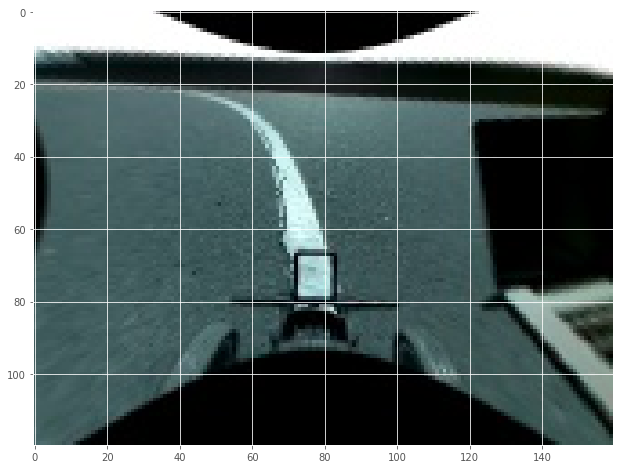

In [117]:
model = keras.models.load_model('../../donkeycar/d2/models/ws.nb.3fc_l1.undistort.0.06')
model1 = keras.models.load_model('../../donkeycar/d2/models/ws.nb.3fc_l2.0.011')
model2 = keras.models.load_model('../../donkeycar/d2/models/ws.nb.3fc_l1.newundist.0.071')
img_in = np.array(Image.open("/Users/kenneth/Desktop/jpgs/jpgs/18:28:19.711078_[[ 0.18700044]].jpg"))
plt.imshow(img_in)
model.predict(img_in.reshape((1,) + img_in.shape))

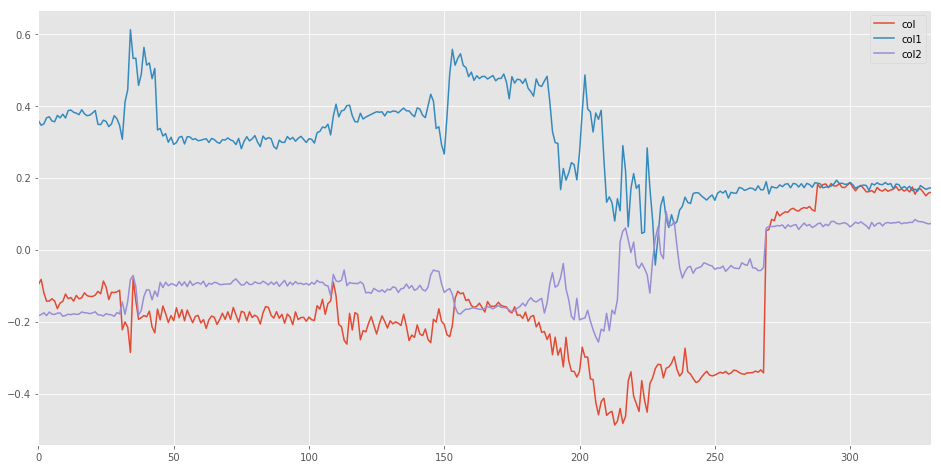

In [118]:
imgs = [ os.path.join("/Users/kenneth/Desktop/jpgs/jpgs/", f) for f in os.listdir("/Users/kenneth/Desktop/jpgs/jpgs/")]
img_arr = np.asarray([np.array(Image.open(i)) for i in imgs])
angle, throttle = model.predict(img_arr)
angle1, throttle = model1.predict(img_arr)
angle2, throttle = model2.predict(img_arr)
# angle2 = unbin_Y(angle2)
df = pd.DataFrame({'col1': angle1[:,0], 'col': angle[:,0], 'col2': angle2[:,0]}, index=range(angle.shape[0]))
df.plot()

[array([[-0.15596928]], dtype=float32), array([[ 0.20853855]], dtype=float32)]

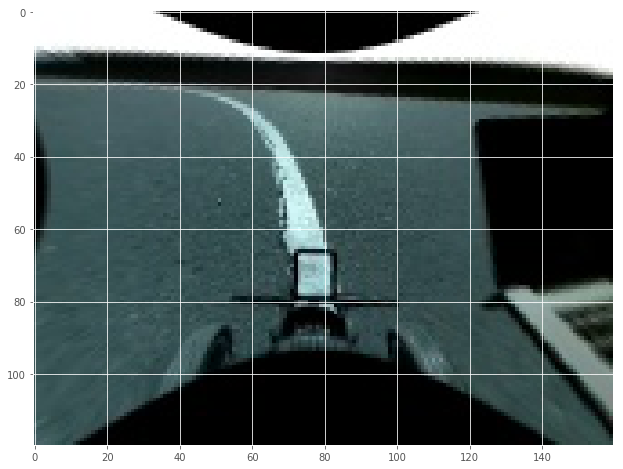

In [63]:
img_in1 = np.array(Image.open("/Users/kenneth/Desktop/jpgs/jpgs/18:27:26.719741_[[-0.3828941]].jpg"))
plt.imshow(img_in1)
model.predict(img_in1.reshape((1,) + img_in.shape))

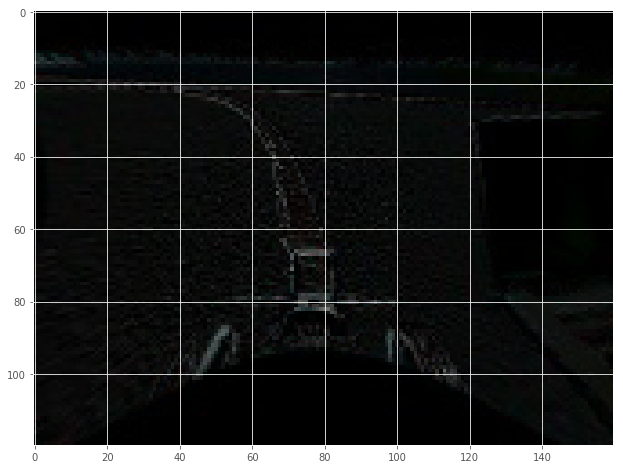

In [56]:
plt.imshow(np.absolute(img_in.astype('float') - img_in1.astype('float')).astype('uint8'))

In [12]:
model = keras.models.load_model('../../donkeycar/d2/models/ws.nb.3fc_l1.undistort.0.06')
dataset = dataset_from_tub("data.ws.test/tub_1_17-09-23", limit=-1)
predicted, actual = output_pair_cat(model, dataset)
df = pd.DataFrame(dict(predicted=predicted, actual=actual))
df = df.rolling(5, win_type='triang').mean()
df.plot()
np.absolute(df['actual'] - df['predicted']).mean()

NameError: name 'dataset_from_tub' is not defined

In [16]:
eval_ds = dataset_from_all_tubs("/home/ubuntu/donkeycar/d2/data.ws.test")
# eval_ds = dataset_from_tub("/home/ubuntu/donkeycar/d2/data.ws.test/tub_1_17-09-23", limit=-1)
model = keras.models.load_model('/home/ubuntu/donkeycar/d2/models/ws.nb.undistort')

model.evaluate(x={"img_in": eval_ds[0]},
          y={"angle_out": bin_angle_out(eval_ds[1]), "throttle_out": eval_ds[2]},
          batch_size=128,
          verbose=2)

Tub does exist


[0.8573345150092877, 0.95252450033951175, 0.0624858148156439]

Tub does exist
Tub does exist
Tub does exist


0.0664331582011312

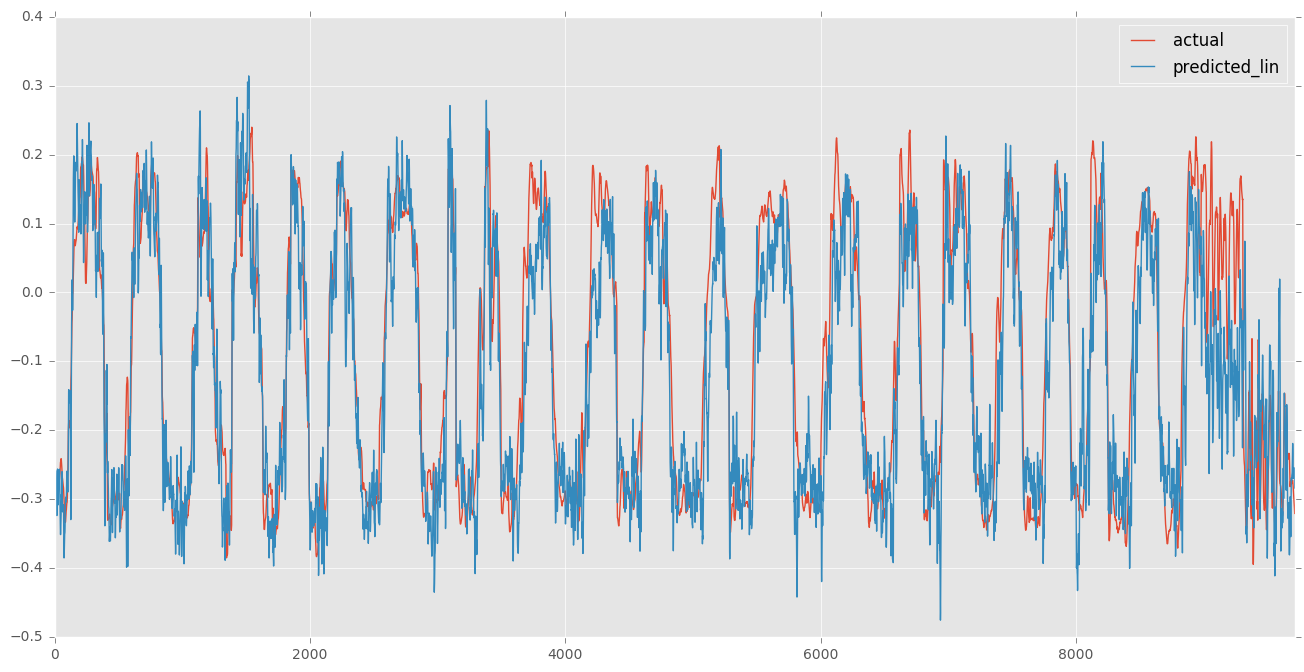

In [33]:
dataset = dataset_from_all_tubs("/home/ubuntu/donkeycar/d2/data.ws.test")
# dataset = dataset_from_tub("/home/ubuntu/donkeycar/d2/data.ws.test/tub_1_17-09-23", limit=-1)
# dataset = (np.asarray([undistort(img, balance=0.6) for img in dataset[0]]), dataset[1], dataset[2])
model = keras.models.load_model('/home/ubuntu/donkeycar/d2/models/ws.nb.3fc_1l.gen.0.0562')

predicted_lin, actual = output_pair_lin(model, dataset)
df = pd.DataFrame(dict(predicted_lin=predicted_lin[:,0], actual=actual))
df = df.rolling(5, win_type='triang').mean()
df.plot()
np.absolute(df['actual'] - df['predicted_lin']).mean()